<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/openai/CLIP

https://www.geeksforgeeks.org/image-classification-using-cifar-10-and-cifar-100-dataset-in-tensorflow/

In [ ]:
!pip install ftfy regex tqdm -q

#!pip install colab-env --upgrade -q
#!pip install openai -q

!pip install git+https://github.com/openai/CLIP.git


import matplotlib.pyplot as plt

In [2]:
#import colab_env
#import os

#import openai
##openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
!nvidia-smi

Thu Apr 11 08:20:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   31C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!git clone https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 2 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [16]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("/content/CLIP/CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = 100 * logits_per_image.softmax(dim=-1).cpu().numpy()


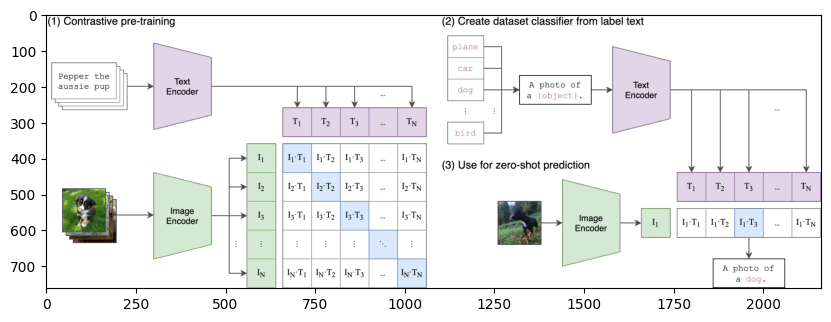

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(Image.open("/content/CLIP/CLIP.png"))
plt.show()

In [22]:
print(["a diagram", "a dog", "a cat"])
print("Label probs:", probs)

['a diagram', 'a dog', 'a cat']
Label probs: [[99.25    0.4185  0.3015]]


In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=True)

# Prepare the inputs
image, class_id = cifar100[3637]
#image, class_id = cifar100[43]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)


# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 10 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(10)

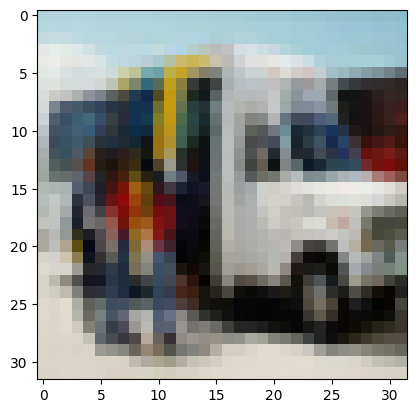

In [10]:
#plt.figure(figsize=(10, 10))
#plt.figure(figsize=(10, 10))
#plt.imshow(image)
import numpy as np

arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=256)
plt.imshow(np.array(image).astype("uint64"))

gray_image=image.convert('L')

#convert image to NumPy array
gray_image_array=np.asarray(gray_image)

#display image on grayscale
#plt.imshow(gray_image_array, cmap='gray')
plt.show()


In [11]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

    pickup_truck: 94.58%
             bus: 2.19%
    sweet_pepper: 0.46%
         tractor: 0.34%
      lawn_mower: 0.20%
          cattle: 0.17%
       palm_tree: 0.15%
           train: 0.14%
           plain: 0.13%
        wardrobe: 0.09%


In [ ]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1) ## Accuracy = 80.020
#classifier = LogisticRegression(random_state=0, C=0.316, max_iter=800, verbose=1) ## Accuracy = 79.940
classifier.fit(train_features, train_labels)

In [13]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 80.020
